In [1]:
%matplotlib inline
from utils import *

## Neuron params

In [2]:
# Default params
R_m = 142 * 1e6                                     # 142 MΩ
V_th = 15 * 1e-3                                    # 15 mV
tau_m = 24 * 1e-3                                   # 24 ms
f = 5                                               # 5 Hz
omega = 2 * np.pi * f                               # 5 Hz in rad/s
I_osc = 40 * 1e-12                                  # 40 pA
M = 5                                               # number of input levels
range_frac = 0.75                                   # fraction of range to use
sigma_w_avg = 0.0135                                # average sigma_w
eta = sigma_w_to_eta(sigma_w_avg, V_th, tau_m, f)   # noise strength (default: 0.14)

## Simulation params

In [3]:
# Change some params
f = 5                        # Hz
eta = 0.05 #0.11             # a.u.

# Simulation parameters
dt = 1e-4                    # Time step for numerical integration
t_end = 2 / f                # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 10000           # Number of trials

## Run simulation

In [4]:
# Run the simulation and store voltage trajectories
all_res = get_distr_empirical(R_m, V_th, eta, tau_m, I_osc, f, M, dt, t, num_trials, range_frac, store_trajectories=True)
means, variances, all_phis, Is_range, all_voltages, all_first_spike_times, all_phi_0 = all_res

## B - Example traces and probability distributions

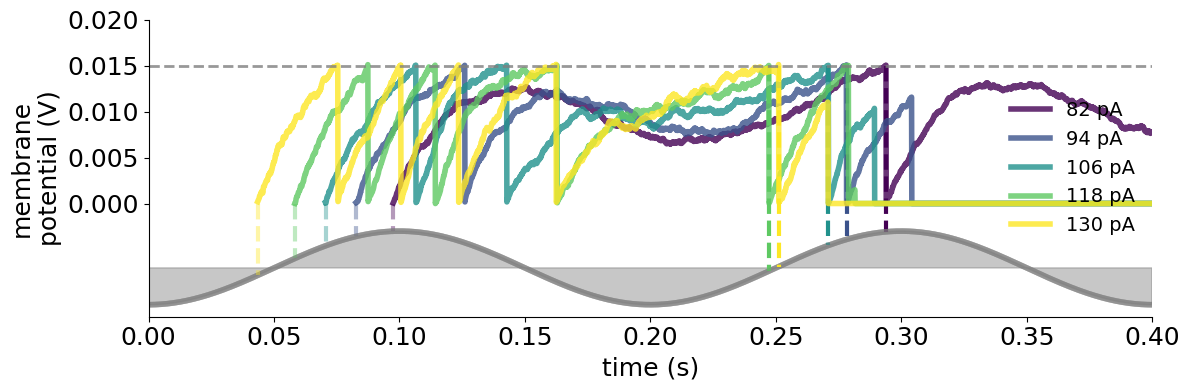

In [5]:
plt.figure(figsize=(12, 4))

colors = cm.viridis(np.linspace(0, 1, len(all_voltages)))

for i, (voltage_trajectory, first_spike_times, phi_0) in enumerate(zip(all_voltages, all_first_spike_times, all_phi_0)):
    neuron_index = 5  # Choosing the first neuron as an example
    shift = -int(phi_0 / (2 * np.pi * f) / dt)
    t_temp = roll_with_nan(t, shift)
    color = colors[i % len(colors)]
    plt.plot(t_temp, voltage_trajectory[:, neuron_index], label=f'{Is_range[i]*1e12:.0f} pA', color=color, alpha=0.8, linewidth=4)
    
    # Plot the cosine oscillation
    oscillation = I_osc * np.cos(2 * np.pi * f * t - np.pi) * 1e8 - 0.007
    plt.plot(t, oscillation, '-', color='#7f7f7f', alpha=0.3, linewidth=4)
    
    # Calculate the midpoint of the oscillation
    midpoint = (np.max(oscillation) + np.min(oscillation)) / 2

    # Fill between the midpoint line and the cosine wave for both peaks and troughs
    plt.fill_between(t, midpoint, oscillation, where=(oscillation >= midpoint), color='#7f7f7f', alpha=0.1)
    plt.fill_between(t, midpoint, oscillation, where=(oscillation < midpoint), color='#7f7f7f', alpha=0.1)

    spike_time = first_spike_times[neuron_index] + phi_0/(2*np.pi*f)
    if not np.isnan(spike_time):
        spike_osc_value = I_osc * np.cos(2 * np.pi * f * spike_time - np.pi) * 1e8 - 0.007
        plt.plot([spike_time, spike_time], [V_th, spike_osc_value], color=color, linestyle='--', linewidth=3, alpha=1)
    
    phi_0_time = phi_0/(2*np.pi*f)
    phi_0_osc_value = I_osc * np.cos(2 * np.pi * f * phi_0_time - np.pi) * 1e8 - 0.007
    plt.plot([phi_0_time, phi_0_time], [0, phi_0_osc_value], color=color, linestyle='--', linewidth=3, alpha=0.4)

# Add a horizontal line at the midpoint of the oscillation
#plt.axhline(midpoint, color=modern_blue, linestyle='--', alpha=0.8, linewidth=2)

plt.xlim(0, 0.4)

plt.axhline(V_th, color='#7f7f7f', linestyle='--', alpha=0.8, linewidth=2)

plt.xlabel('time (s)', fontsize=18)

# Update ylabel placement
plt.ylabel('membrane\npotential (V)', fontsize=18)

# Update legend position
plt.legend(loc='center right', frameon=False, fontsize=14)

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)

# Remove y-ticks below 0
current_yticks = plt.gca().get_yticks()
new_yticks = [ytick for ytick in current_yticks if ytick >= 0]
plt.gca().set_yticks(new_yticks)

sb.despine()
plt.tight_layout()

#plt.savefig('plots/fig1/fig1A_voltageTraj_v3.svg', dpi=600)

plt.show()

C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


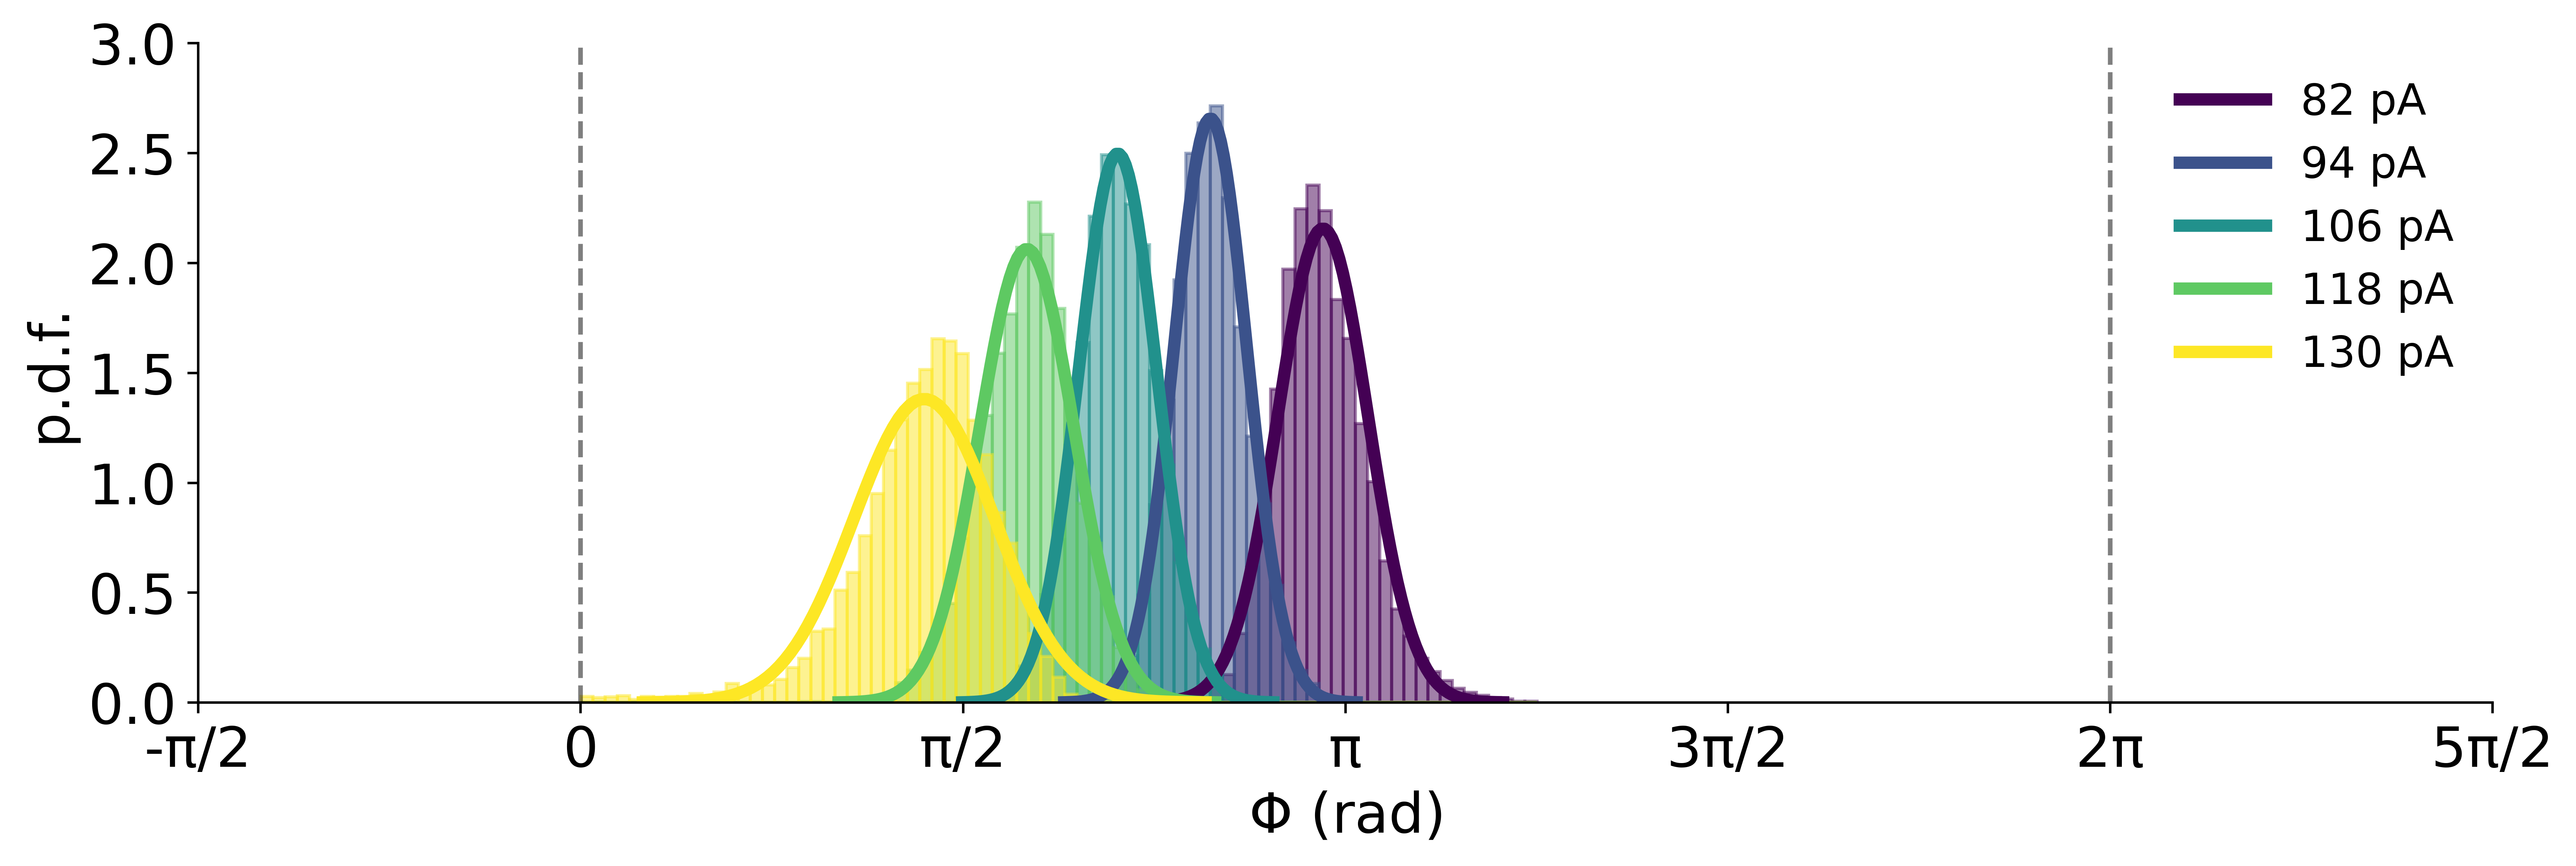

In [6]:
# Plotting the results
plt.figure(figsize=(11.7, 4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.viridis(np.linspace(0, 1, M))
#c = ['#9467bd',  '#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

# Combine all_phis to calculate a common bin range
bin_edges = np.histogram_bin_edges(np.concatenate(all_phis), bins='auto')

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='-', color=c[i], label=str(int(np.around(Is*1e12)))+" pA")
    #plt.hist(all_phis[i], bins='auto', density=True, color=c[i], alpha=.5)
    plt.hist(all_phis[i], bins=bin_edges, density=True, color=c[i], alpha=.5, edgecolor=c[i])

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f.', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=18)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 3)
plt.yticks(fontsize=18)

plt.axvline(0, linestyle='--', color='k', alpha=0.5)
plt.axvline(2 * np.pi, linestyle='--', color='k', alpha=0.5)

sb.despine()
plt.tight_layout()

#plt.savefig('plots/fig1/fig1B_phaseDistr.svg', dpi=600)

plt.show()

### Simpler plot

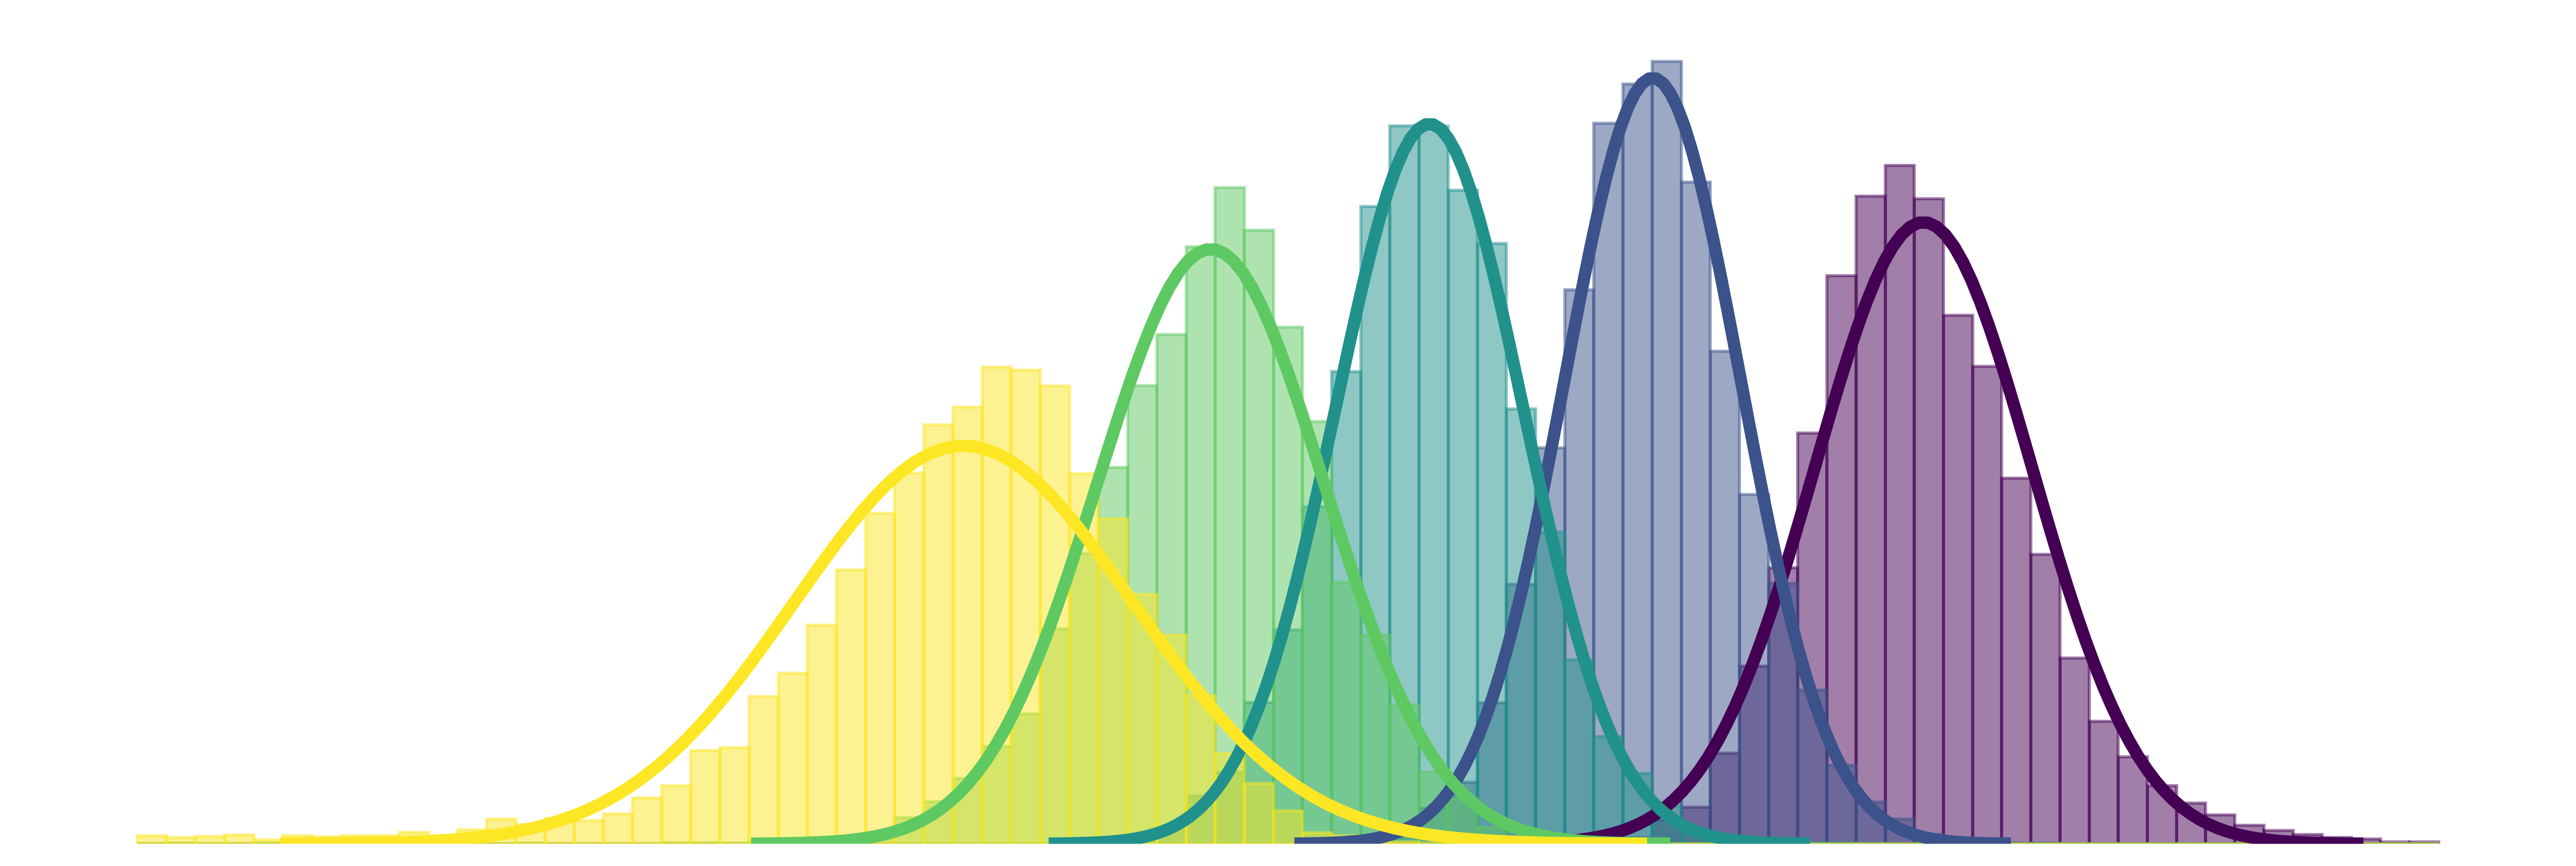

In [7]:
# Plotting the results
plt.figure(figsize=(11.7, 4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.viridis(np.linspace(0, 1, M))
#c = ['#9467bd',  '#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

# Combine all_phis to calculate a common bin range
bin_edges = np.histogram_bin_edges(np.concatenate(all_phis), bins='auto')

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='-', color=c[i], label=str(int(np.around(Is*1e12)))+" pA")
    #plt.hist(all_phis[i], bins='auto', density=True, color=c[i], alpha=.5)
    plt.hist(all_phis[i], bins=bin_edges, density=True, color=c[i], alpha=.5, edgecolor=c[i])

plt.axis('off')

plt.tight_layout()

#plt.savefig('plots/fig1/fig1B_phaseDistr_simple_v2.svg', dpi=600)

plt.show()